### Denoising using Scaterring Covariance

This notebook provides a simplified example of how to use scattering covariance to distinguish between noise and the signal of interest. The observational data model $d$ is given by: 

$d = s + n$. 

In this context, $s$ is represented by a 2D smiley picture and $n$ is white noise. We assume there are $n_{noise}=100$ noise realizations. We define two loss functions: 

$L_1 = \sum_{n_{noise}}{\frac{{(\Phi(d)-\Phi(s+n))}^2}{\sigma_{n}^2}}$, 

and 

$L_2 = \sum_{n_{noise}}{\frac{{(\Phi(d,s)-\Phi(s+n,s))}^2}{\sigma_{x}^2}}$.

Given that noise-induced biases are related to the signal of interest, the algorithm employs two iteration types. The first type minimizes the $L_1$ and $L_2$ losses to produce a signal model $s*$. The second type, termed an epoch to avoid confusion, updates the definition of $s*$, where $s*$ is initially $d$ and subsequently is the retrieved $s$ from the prior epoch. Consequently, $\sigma_{n}$ is the standard deviation of $\Phi(s*+n)-\Phi(s*)$, and $\sigma_{x}$ is the standard deviation of $\Phi(s*+n,s*)-\Phi(s*,s*)$.

In [1]:
#Call the foscat library
!pip install foscat==3.1.6

In [2]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import foscat.Synthesis as synthe

## Initialize data

The signal of interest is a 2D smiley picture downgraded to xsize=64 to make it run faster. The value range is [0,1].

In [3]:
xsize=64
# number of noise to learn statistics
nnoise=100

# amplitude of the white noise
ampnoise=0.3

# Load the smiley picture

([], [])

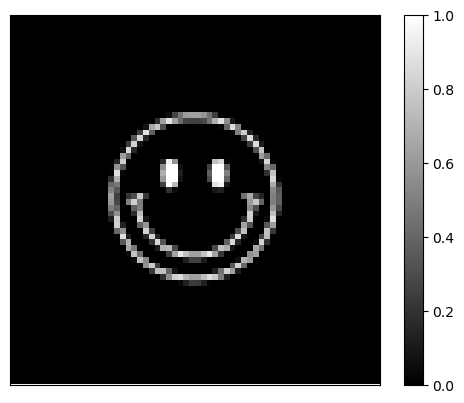

In [4]:
from PIL import Image

SMILEY_IMAGE = 'data/smiley-face-svg-rogne.jpg'
img = Image.open(SMILEY_IMAGE)
smiley=np.zeros([512,512])
smiley[256-128:256+128,256-128:256+128] = 1.0*(np.asarray(img)[:,:,0]<128)

# de zoom at the xsize scale
smiley=np.sum(np.sum(smiley.reshape(xsize,512//xsize,xsize,512//xsize),3),1)/(512/xsize)**2
plt.imshow(smiley,cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])

# compute noise population

In [5]:
noise=ampnoise*np.random.randn(nnoise,xsize,xsize)

# Define the Scaterring Covariance statistics

In [6]:
import foscat.scat_cov2D as sc
print('Work with ScatCov')

scat_op=sc.funct(KERNELSZ=5)

Work with ScatCov
          START FOSCAT CONFIGURATION


2024-10-02 15:32:53.005950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 15:32:53.005984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 15:32:53.006985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 15:32:53.010743: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
==                                                        ==
==                                                        ==
==     RUN ON GPU Rank 0 : /device:GPU:0                          ==
==                                                        ==
==                                                        ==


2024-10-02 15:32:55.072045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:61:00.0, compute capability: 8.0


## define the statistics

the eval_scat function defines how the statistics are computed using foscat.

In [7]:
def eval_scat(sc,x,image2=None,mask=None):
    return sc.eval(x,image2=image2,mask=mask).flatten()

In [8]:
# compute statistics for the smiley and the smiley+noise

ref=scat_op.eval(smiley)
nref=scat_op.eval(smiley+noise[0])

2024-10-02 15:32:55.198100: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


Text(0.5, 1.0, 'Measured data')

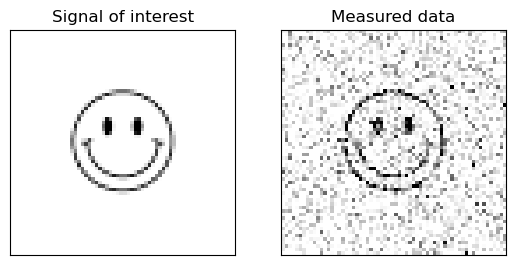

In [9]:

# shows both pictures

plt.subplot(1,2,1)
plt.imshow(smiley,vmin=0,vmax=1,cmap='Grays')
plt.xticks([])
plt.yticks([])
plt.title('Signal of interest')
plt.subplot(1,2,2)
plt.imshow(smiley+noise[0],vmin=0,vmax=1,cmap='Grays')
plt.xticks([])
plt.yticks([])
plt.title('Measured data')

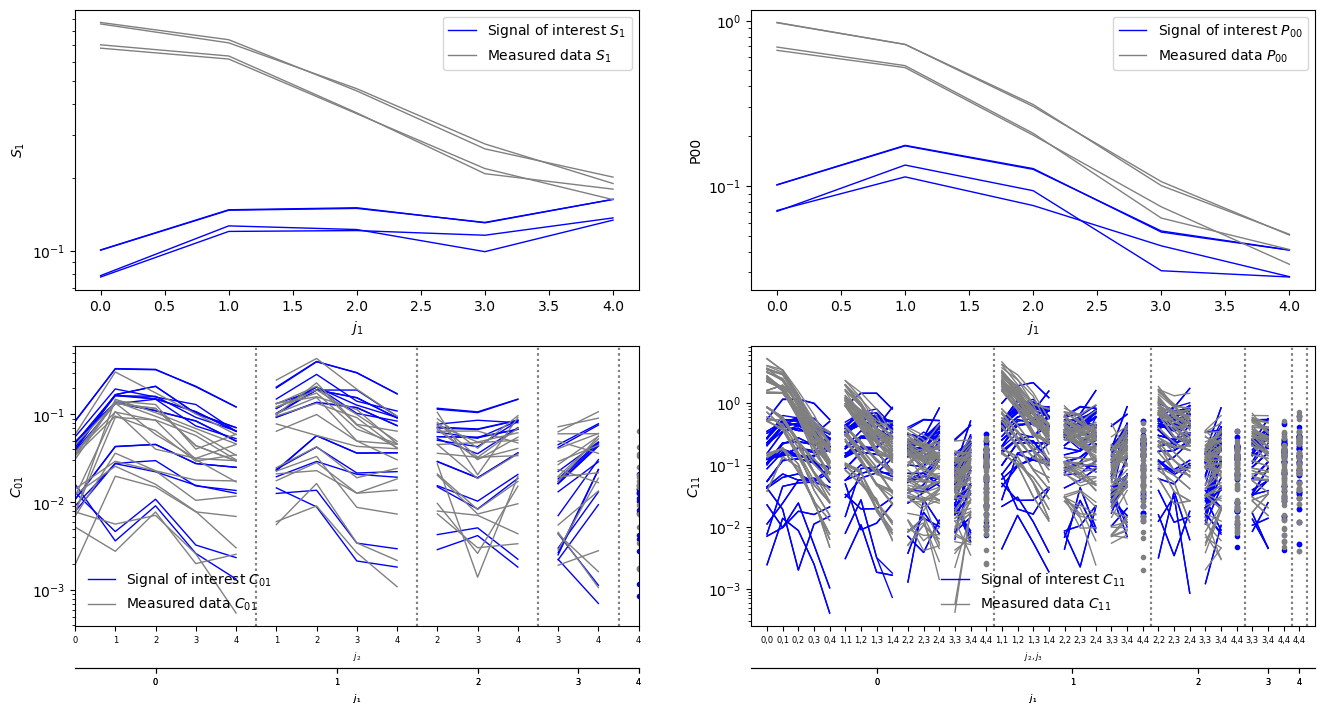

In [10]:
# show both statistics

ref.plot(name='Signal of interest')
nref.plot(hold=False,color='grey',name='Measured data')

# Start the statistical cleanning

We define here an image to be cleaned called *im* and at the first epoch *imref*=*im* to compute the bias and the statistics.

In [11]:
#=================================================================================
# DEFINE The LOSS FUNCTION AND THE SYNTHESIS
#=================================================================================

# \Phi(d) \simeq \Phi(u + n),
def The_loss_1(x,scat_operator,args,return_all=False):

    ref  = args[0]
    bref = args[1]
    vref = args[2]
    im   = args[3]

    learn=eval_scat(scat_operator,im-x)+bref
    loss=scat_operator.reduce_mean(scat_operator.square((ref-learn)/vref))

    return(loss)

# \Phi(u,d) \simeq \Phi(u,u+n),
def The_loss_2(x,scat_operator,args,return_all=False):

    bref = args[0]
    vref = args[1]
    im   = args[2]

    learn=eval_scat(scat_operator,im-x,image2=im)
    ref=eval_scat(scat_operator,im-x,image2=im-x)+bref
    loss=scat_operator.reduce_mean(scat_operator.square((ref-learn)/vref))

    return(loss)

In [12]:
im = smiley+ampnoise*np.random.randn(xsize,xsize)

imref=im.copy()

# compute the statistics for the two losses
tref=eval_scat(scat_op,imref)
cref=eval_scat(scat_op,imref,image2=imref)

tmp1=np.zeros([nnoise,tref.shape[1]],dtype='complex')
tmp2=np.zeros([nnoise,cref.shape[1]],dtype='complex')
for k in range(nnoise):
    tmp1[k]=(eval_scat(scat_op,imref+noise[k])-tref)[0]
    tmp2[k]=(eval_scat(scat_op,imref,image2=imref+noise[k])-cref)[0]

In [13]:
# compute the bias and sigma related to the noise and imref of the given epoch
bias_1=scat_op.backend.bk_cast(np.mean(tmp1,0))
sigma_1=scat_op.backend.bk_cast(np.std(tmp1,0)+0J)
bias_2=scat_op.backend.bk_cast(np.mean(tmp2,0))
sigma_2=scat_op.backend.bk_cast(np.std(tmp2,0)+0J)

In [14]:
# compute the observe statistics
ref1=eval_scat(scat_op,im)

# declare the loss function used for the synthesis

Here is a small trick related to Tensorflow backend that avoid to recompute the graph at every epoch.

In [15]:
# constant information within all epochs
c_ref1=scat_op.backend.backend.constant(ref1)
c_im = scat_op.backend.backend.constant(im)

# variable information within all epochs
v_bias_1=scat_op.backend.backend.Variable(bias_1)
v_sigma_1=scat_op.backend.backend.Variable(sigma_1)
v_bias_2=scat_op.backend.backend.Variable(bias_2)
v_sigma_2=scat_op.backend.backend.Variable(sigma_2)

#decle the loss class
loss1=synthe.Loss(The_loss_1,scat_op,c_ref1,v_bias_1,v_sigma_1,c_im)
loss2=synthe.Loss(The_loss_2,scat_op,v_bias_2,v_sigma_2,c_im)

# define the foscat synthesis using the two previous loss
sy = synthe.Synthesis([loss1,loss2])

In [16]:
imap=np.random.randn(xsize,xsize)*1E-6
omap=sy.run(scat_op.backend.bk_cast(imap),
                            EVAL_FREQUENCY=50,
                            NUM_EPOCHS = 300)

Total number of loss  2
 Run [PROC=0000] on GPU /device:GPU:0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 Run [PROC=0000] on GPU /device:GPU:0
Itt      0 L=      8.48 (      13.1       3.85 ) 43.690s 
Itt     50 L=     0.268 (     0.404      0.132 ) 4.393s 
Itt    100 L=      0.26 (     0.392      0.

Input noise Level 0.300, Output noise Level 0.179, Gain ratio 1.68


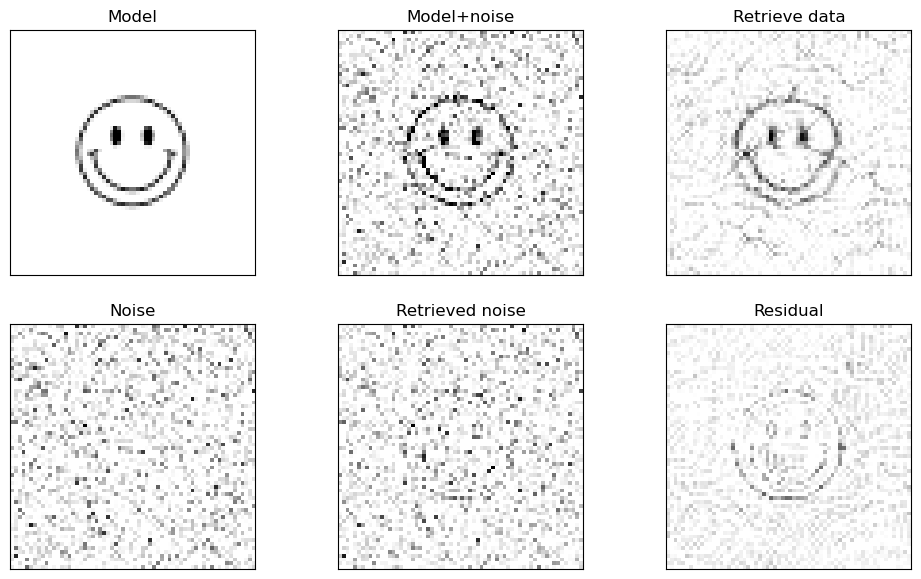

In [17]:
# let's have a look after the first epoch
res=omap.numpy().copy()
def draw_pict(value,order,title):
    plt.subplot(2,3,1+order)
    plt.title(title)
    plt.imshow(value,vmin=0,vmax=1,cmap='Greys')
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(12,7))
draw_pict(smiley,0,'Model')
draw_pict(im,1,'Model+noise')
draw_pict(im-res,2,'Retrieved data')
draw_pict(im-smiley,3,'Noise')
draw_pict(res,4,'Retrieved noise')
draw_pict(res-(im-smiley),5,'Residual')
draw_pict(im-res,2,'Retrieve data')

a=np.std(im-smiley)
b=np.std(im-smiley-res)
print("Input noise Level %.3f, Output noise Level %.3f, Gain ratio %.2f"%(a,b,a/b))

# now run other epoch

In [ ]:
# prepare a list to store the result at each epoch
omap={}
omap[0]=res

nitt=3
for itt in range(nitt):
    imref=im-omap[itt]
    
    # compute the statistics for the two losses
    tref=eval_scat(scat_op,imref)
    cref=eval_scat(scat_op,imref,image2=imref)

    tmp1=np.zeros([nnoise,tref.shape[1]],dtype='complex')
    tmp2=np.zeros([nnoise,cref.shape[1]],dtype='complex')
    for k in range(nnoise):
        tmp1[k]=(eval_scat(scat_op,imref+noise[k])-tref)[0]
        tmp2[k]=(eval_scat(scat_op,imref,image2=imref+noise[k])-cref)[0]

    # compute the bias and sigma related to the noise and imref of the given epoch
    bias_1=scat_op.backend.bk_cast(np.mean(tmp1,0))
    sigma_1=scat_op.backend.bk_cast(np.std(tmp1,0)+0J)
    bias_2=scat_op.backend.bk_cast(np.mean(tmp2,0))
    sigma_2=scat_op.backend.bk_cast(np.std(tmp2,0)+0J)

    # assign new values for the minimisation
    v_bias_1.assign(bias_1)
    v_sigma_1.assign(sigma_1)
    v_bias_2.assign(bias_2)
    v_sigma_2.assign(sigma_2)

    # compute 
    imap=np.random.randn(xsize,xsize)*1E-6
    omap[itt+1]=sy.run(scat_op.backend.bk_cast(imap),
                                EVAL_FREQUENCY=50,
                                NUM_EPOCHS = 300)

    a=np.std(im-smiley)
    b=np.std(im-smiley-omap[itt+1])
    print("Input noise Level %.2f, Output noise Level %.2f, Gain ratio %.2f"%(a,b,a/b))

Total number of loss  2
Itt      0 L=      17.5 (      30.9       4.15 ) 0.069s 
Itt     50 L=     0.309 (     0.478      0.141 ) 4.481s 
Itt    100 L=     0.293 (     0.453      0.133 ) 3.893s 
Itt    150 L=     0.288 (     0.447      0.128 ) 3.977s 
Itt    200 L=     0.285 (     0.444      0.127 ) 4.285s 
Itt    250 L=     0.284 (     0.442      0.126 ) 4.071s 
Itt    300 L=     0.282 (     0.439      0.126 ) 4.620s 
Input noise Level 0.30, Output noise Level 0.14, Gain ratio 2.09
Total number of loss  2
Itt      0 L=        21 (      38.2       3.73 ) 0.090s 
Itt     50 L=     0.313 (     0.475      0.151 ) 4.045s 
Itt    100 L=     0.296 (     0.452       0.14 ) 3.915s 
Itt    150 L=     0.291 (     0.444      0.138 ) 3.947s 
Itt    200 L=      0.29 (     0.443      0.137 ) 5.114s 
Itt    250 L=     0.289 (     0.442      0.136 ) 4.102s 
Itt    300 L=     0.288 (     0.441      0.136 ) 3.896s 
Input noise Level 0.30, Output noise Level 0.13, Gain ratio 2.27


In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,5,1)
plt.title('Input Data')
plt.imshow(im,vmin=0,vmax=1,cmap='Greys')
plt.xticks([])
plt.yticks([])
for itt in range(nitt+1):
    a=np.std(im-smiley)
    b=np.std(im-smiley-omap[itt])
    plt.subplot(1,5,2+itt)
    plt.title('Itteration #%d (%.2f)'%(itt,a/b))
    plt.imshow(im-omap[itt],vmin=0,vmax=1,cmap='Grays')
    plt.xticks([])
    plt.yticks([])

### Mask region to optimise the result

If the region where the signal of interest is known to be 0, it is possible to force the statistic using a mask while computing the SC biases and variance.

In [ ]:
# add a mask to the statistics, as we know that the smiley is at the center

x,y=np.meshgrid(np.arange(xsize)+0.5-xsize/2,np.arange(xsize)+0.5-xsize/2)
mask=(x*x+y*y)<(xsize/4)**2

# prepare a list to store the result at each epoch
omap={}
omap[0]=res

nitt=3
for itt in range(nitt):
    imref=(im-omap[itt])*mask
    
    # compute the statistics for the two losses
    tref=eval_scat(scat_op,imref)
    cref=eval_scat(scat_op,imref,image2=imref)

    tmp1=np.zeros([nnoise,tref.shape[1]],dtype='complex')
    tmp2=np.zeros([nnoise,cref.shape[1]],dtype='complex')
    for k in range(nnoise):
        tmp1[k]=(eval_scat(scat_op,imref+noise[k])-tref)[0]
        tmp2[k]=(eval_scat(scat_op,imref,image2=imref+noise[k])-cref)[0]

    # compute the bias and sigma related to the noise and imref of the given epoch
    bias_1=scat_op.backend.bk_cast(np.mean(tmp1,0))
    sigma_1=scat_op.backend.bk_cast(np.std(tmp1,0)+0J)
    bias_2=scat_op.backend.bk_cast(np.mean(tmp2,0))
    sigma_2=scat_op.backend.bk_cast(np.std(tmp2,0)+0J)

    # assign new values for the minimisation
    v_bias_1.assign(bias_1)
    v_sigma_1.assign(sigma_1)
    v_bias_2.assign(bias_2)
    v_sigma_2.assign(sigma_2)

    # compute 
    imap=np.random.randn(xsize,xsize)*1E-6
    omap[itt+1]=sy.run(scat_op.backend.bk_cast(imap),
                                EVAL_FREQUENCY=50,
                                NUM_EPOCHS = 300)

    a=np.std(im-smiley)
    b=np.std(im-smiley-omap[itt+1])
    print("Input noise Level %.2f, Output noise Level %.2f, Gain ratio %.2f"%(a,b,a/b))

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,5,1)
plt.title('Input Data')
plt.imshow(im,vmin=0,vmax=1,cmap='Greys')
plt.xticks([])
plt.yticks([])
for itt in range(nitt+1):
    a=np.std(im-smiley)
    b=np.std(im-smiley-omap[itt])
    plt.subplot(1,5,2+itt)
    plt.title('Itteration #%d (%.2f)'%(itt,a/b))
    plt.imshow(im-omap[itt],vmin=0,vmax=1,cmap='Grays')
    plt.xticks([])
    plt.yticks([])